[← Back to Index](../index)

# Intro
- All step tracker log files are stored in `\Logs` and were recorded using [AccelRecorder](https://github.com/makeabilitylab/arduino/tree/master/Processing/AccelRecorder) in Processing
- The filenames are labeled descriptively and include: where the sensor was worn, the number of steps per set, the number of sets, and information about the sampling and serial communication. For example `arduino_accel_lefthoodiepocket_3sets_15steps_nodelay_115200baud.csv` was recorded with the ESP32 and LIS3DH sensor in my left hoodie pocket. I took three sets of 15 steps. The [Arduino program](https://github.com/makeabilitylab/arduino/blob/master/Processing/AccelRecorder/Arduino/LIS3DHSerialWriter/LIS3DHSerialWriter.ino) had no delays (sampling sensor as fast as possible) and communicated over serial at a baud rate of 115200.
- Most of my samples have sets of 15 strides or "steps" (length of my hallway). See filename. There is a pecularity for the "last step" ocassionally where I've completed the 15th stride but then I bring my other leg to be in parallel so that I'm in a standing position. So, really, my data either has 15 or 16 steps in it.
- The most challenging file is `arduino_accel_leftwrist_15steps_3hops_3halfspin_3touchceiling_thenshake_nodelay_115200.csv`, which has 15 steps followed by 3 jumps (hops), 3 half spins, 3 ceiling touches, and then some massive shakes. Can you detect the steps here and ignore the other activities?


## Record your own data!

You can record, visualize, and analyze your own step tracker accelerometer data using [AccelRecorder](https://github.com/makeabilitylab/arduino/tree/master/Processing/AccelRecorder). You must also be running [LIS3DHSerialWriter.ino
](https://github.com/makeabilitylab/arduino/blob/master/Processing/AccelRecorder/Arduino/LIS3DHSerialWriter/LIS3DHSerialWriter.ino) on your Arduino. See video below. Note that my screen recording software was impacting my real-time visualization frame rates (but the underlying recorded data is not impacted).


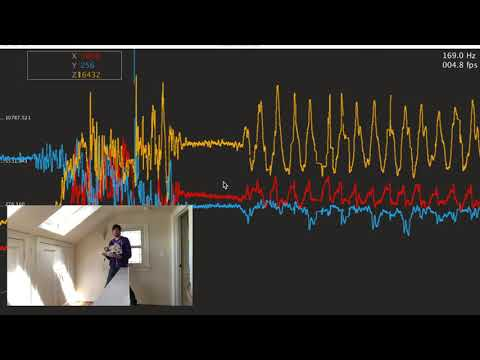

In [1]:
from IPython.lib.display import YouTubeVideo
# https://www.youtube.com/watch?v=k1HvoYhnwXE
YouTubeVideo('k1HvoYhnwXE', width=800, height=450)

# Load step tracker data

In [2]:
# Import the primary data analysis libraries
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal

In [3]:
import os

log_path = 'Logs'
files_in_log_path = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]

print("The following files are available to load in the '{}' dir: ".format(log_path))
for filename in files_in_log_path:
    print(filename)

The following files are available to load in the 'Logs' dir: 
received_data_2024-02-07_010818.txt


In [4]:
# Load in the data from one of the files

#log_filename = 'arduino_accel_leftwrist_15steps_3hops_3halfspin_3touchceiling_thenshake_nodelay_115200.csv'
#log_filename = 'arduino_accel_lefthoodiepocket_3sets_15steps_nodelay_115200baud_subset.csv'
#log_filename = 'arduino_accel_leftwrist_3sets_15steps_leftwrist_nodelay_115200.csv'
# log_filename = 'arduino_accel_righthoodiepocket_3sets_15steps_delay10_9600baud_subset.csv'
#log_filename = 'arduino_accel_leftwrist_15steps_3hops_3halfspin_3touchceiling_thenshake_nodelay_115200.csv'
log_filename = "received_data_2024-02-07_010818.txt"
log_filename_with_path = os.path.join(log_path, log_filename)

# Use loadtxt to load and parse csv data. 
# https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html?highlight=loadtxt#numpy.loadtxt
np.loadtxt(log_filename_with_path, delimiter=',', unpack=True, skiprows=1)

raw_data = np.loadtxt(log_filename_with_path, delimiter=',', unpack=True, skiprows=1)
(timestamp, x_raw, y_raw, z_raw, accel_x, accel_y, accel_z) = raw_data

# Calculate the magnitude of the x, y, z acceleration values
# to get the overall "strength" of acceleration at each time step
# Magnitude is a particularly helpful value when working with accelerometers
# because it is orientation agnostic
accel_mag = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
accel_time = timestamp
print("Read in {} samples from {}".format(len(accel_x), log_filename))

Read in 95 samples from received_data_2024-02-07_010818.txt


In [5]:
# Print some stats about the loaded data
import math

sample_time_in_ms = accel_time[-1] - accel_time[0]
sample_time_in_s = sample_time_in_ms / 1000.0
print("Num samples: ", accel_time.size)
print("First timestamp: {} ms".format(int(accel_time[0])))
print("Last timestamp: {} ms".format(int(accel_time[-1])))

# Dive into timestamps a bit to analyze sampling rate over time
map_sec_to_sample_count = dict()
for timestamp_ms in accel_time:
    sec_floor = math.floor(timestamp_ms / 1000.0)
    if sec_floor not in map_sec_to_sample_count:
        map_sec_to_sample_count[sec_floor] = 0
    map_sec_to_sample_count[sec_floor] = map_sec_to_sample_count[sec_floor] + 1

print("Length (raw diff): {} secs".format(sample_time_in_s))
print("Length (rounded ceiling): {} secs".format(len(map_sec_to_sample_count)))

counts = list(map_sec_to_sample_count.values())
np_counts = np.array(counts)
sampling_rate_imprecise = accel_time.size / sample_time_in_s
print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
sampling_rate = np.average(np_counts)
print("More precise sampling rate calc: {:.2f} samples/sec (SD={:.2f} samples/sec)".
      format(sampling_rate, np.std(np_counts)))

print()
print("**Accel stats**")
print("Avg x: {:.2f} (SD={:.2f})".format(np.mean(accel_x), np.std(accel_x)))
print("Avg y: {:.2f} (SD={:.2f})".format(np.mean(accel_y), np.std(accel_y)))
print("Avg z: {:.2f} (SD={:.2f})".format(np.mean(accel_z), np.std(accel_z)))
print("Avg mag: {:.2f} (SD={:.2f})".format(np.mean(accel_mag), np.std(accel_mag)))

# What other descriptive stats may be useful to better understand and assess your signal?

Num samples:  95
First timestamp: 2198 ms
Last timestamp: 26758 ms
Length (raw diff): 24.56 secs
Length (rounded ceiling): 24 secs
Coarse sampling rate: 3.87 samples/sec
More precise sampling rate calc: 3.96 samples/sec (SD=1.40 samples/sec)

**Accel stats**
Avg x: 0.23 (SD=1.38)
Avg y: -6.81 (SD=4.23)
Avg z: 5.53 (SD=2.46)
Avg mag: 10.03 (SD=1.51)


In [6]:
# We can also use pandas to analyze our data. I don't use Pandas that much (I should use it more!)
# but it's incredibly popular in data science. It definitely simplifies things like computing
# descriptive stats.
import pandas as pd

# Make a dataframe (the key data object in pandas)
# We could also use Pandas to load and parse our CSV directly
# https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html#getting-data-in-out
df = pd.DataFrame(list(zip(timestamp, accel_x, accel_y, accel_z, accel_mag)), 
               columns =["Timestamp", "X", "Y", "Z", "Mag"]) 

df.describe()

# We won't be using Pandas anymore below but feel free to explore it more on your own!

,Timestamp,X,Y,Z,Mag
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,13973.200000,0.233053,-6.813684,5.532947,10.032719
std,6874.656475,1.389809,4.252932,2.470031,1.519231
min,2198.000000,-3.260000,-12.160000,2.200000,4.255655
25%,8354.000000,-0.470000,-9.980000,3.650000,9.272977
50%,13083.000000,0.120000,-8.550000,4.470000,10.088037
75%,18913.500000,0.920000,-4.905000,7.670000,10.932579
max,26758.000000,4.900000,6.160000,12.590000,13.797869


# Analyze and visualize the raw data

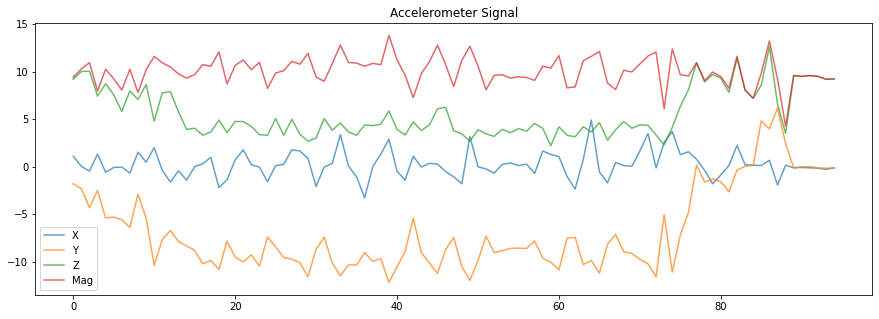

In [7]:
# Now, let's plot the raw x, y, z, and magnitude values
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(accel_x, alpha=0.7, label="X")
axes.plot(accel_y, alpha=0.7, label="Y")
axes.plot(accel_z, alpha=0.7, label="Z")
axes.plot(accel_mag, alpha=0.7, label="Mag")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()

# What do you observe?

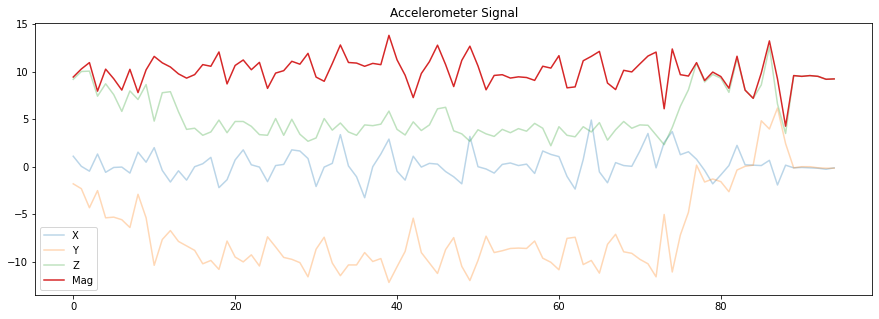

In [8]:
# Let's make another version but this time emphasize the magnitude stream
# Try collecting your own data and switching the orientation of the accelerometer
# between data collection sets. What happens to x,y,z? What happens to the magnitude?
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(accel_x, alpha=0.3, label="X")
axes.plot(accel_y, alpha=0.3, label="Y")
axes.plot(accel_z, alpha=0.3, label="Z")
axes.plot(accel_mag, alpha=1, label="Mag")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()


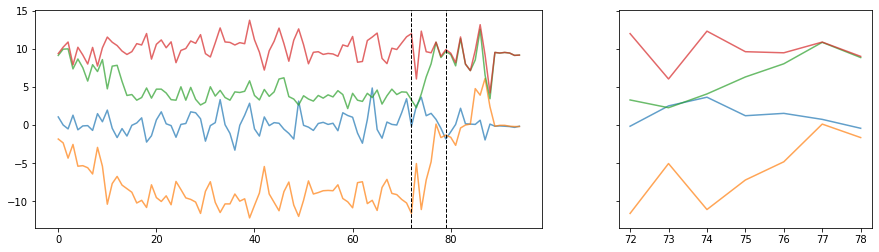

In [9]:
# Often it's useful to show a zoomed in view. We'll select a random 2-sec segment to highlight
import random 

n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]}, sharey='all')
axes[0].plot(accel_x, alpha=0.7, label="X")
axes[0].plot(accel_y, alpha=0.7, label="Y")
axes[0].plot(accel_z, alpha=0.7, label="Z")
axes[0].plot(accel_mag, alpha=0.7, label="Mag")

# show a zoomed in view of ~10 periods
zoom_window_secs = 2
zoom_samples = math.floor(sampling_rate * zoom_window_secs)
zoom_start_index = random.randint(0, len(accel_x) - zoom_samples)
zoom_end_index = zoom_start_index + zoom_samples
zoom_x = list(range(zoom_start_index, zoom_end_index))

axes[1].plot(zoom_x, accel_x[zoom_start_index : zoom_end_index], alpha=0.7, label="X")
axes[1].plot(zoom_x, accel_y[zoom_start_index : zoom_end_index], alpha=0.7, label="Y")
axes[1].plot(zoom_x, accel_z[zoom_start_index : zoom_end_index], alpha=0.7, label="Z")
axes[1].plot(zoom_x, accel_mag[zoom_start_index : zoom_end_index], alpha=0.7, label="Mag")

# highlight where this zoomed view is occurring on main plot
axes[0].axvline(zoom_start_index, linestyle="dashed", linewidth=1, color="black")
axes[0].axvline(zoom_end_index, linestyle="dashed", linewidth=1, color="black")

In [10]:
# Perform some simple frequency analysis. What is the "frequency" of a walk?
# This isn't necessary for the assignment but is interesting to investigate
# And we'll talk more about time vs. frequency domain analysis in the future

# fourier transformations and frequency-based features
num_samples = len(accel_mag)

# the mean substraction removes the y offset before performing FFT
fft = np.abs(np.fft.fft(accel_mag - np.mean(accel_mag)))
freqs = np.fft.fftfreq(len(fft))
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[num_samples//2])))
freqs = freqs[range(num_samples//2)] # one side freq range, integer division
abs_fft = np.abs(fft)[range(num_samples//2)] # one side freq range, integer division
abs_fft_normalized = abs_fft / num_samples # normalize to values 0 - 1

# find the max frequency
max_freq_idx = np.argmax(abs_fft_normalized)
max_freq = freqs[max_freq_idx]
print("The max frequency is: {} Hz".format(max_freq))

# find the top N frequencies
# see: https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array?lq=1
top_n_freq = 3
ind = np.argpartition(abs_fft_normalized, -top_n_freq)[-top_n_freq:] # from https://stackoverflow.com/a/23734295
ind_sorted_by_coef = ind[np.argsort(-abs_fft_normalized[ind])] # reverse sort indices

# I appear to walk at ~1.6 Hz :)
print("Top 3 frequencies (freq, coef):", list(zip(freqs[ind_sorted_by_coef], abs_fft_normalized[ind_sorted_by_coef]))) # print top freq
top1_freq = freqs[ind_sorted_by_coef][0]
top2_freq = freqs[ind_sorted_by_coef][0]
top3_freq = freqs[ind_sorted_by_coef][0]

We have 95 frequency bins of size 0.041666666666666664Hz from 0.0 to 1.9583333333333333Hz
The max frequency is: 0.75 Hz
Top 3 frequencies (freq, coef): [(0.75, 0.43149588242762366), (0.041666666666666664, 0.29674723657830326), (1.0416666666666667, 0.29146445786418396)]


Sampling rate: 3.96 Hz
Maximum detectable frequency in our signal is: 1.98 Hz (due to Nyquist theorem)


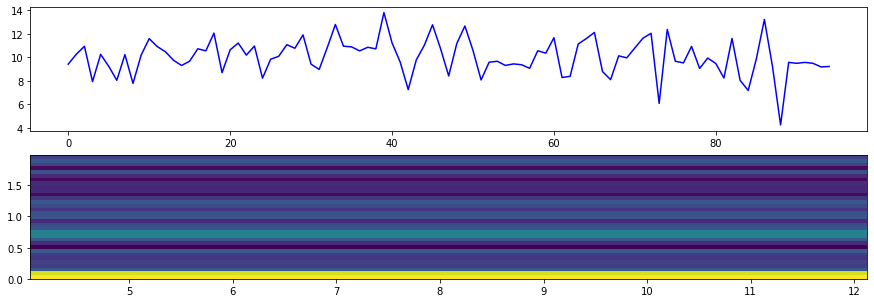

In [11]:
# Visualize the frequency data. In this spectrogram plot, the y-axis is frequency
# and the x-axis is time. We'll talk more about this in the future
# You'll note that most of the frequency is located around 2Hz or less
# See: 
#  - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html
#  - https://matplotlib.org/gallery/images_contours_and_fields/specgram_demo.html

print("Sampling rate: {:0.2f} Hz".format(sampling_rate))
print("Maximum detectable frequency in our signal is: {:.2f} Hz (due to Nyquist theorem)".format(sampling_rate/2.0))

NFFT = 64       # the length of the windowing segments
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(15, 5)) # create two rows, one col of plots

axes1.plot(accel_mag, 'b-', label="netMag Accel")
Pxx, freqs, bins, im = axes2.specgram(accel_mag, NFFT=NFFT, Fs=sampling_rate, noverlap=math.ceil(NFFT/2.0))

# Analyze and visualize transforms of the data
Here, we process the data (e.g., detrend it, smooth it, etc.)

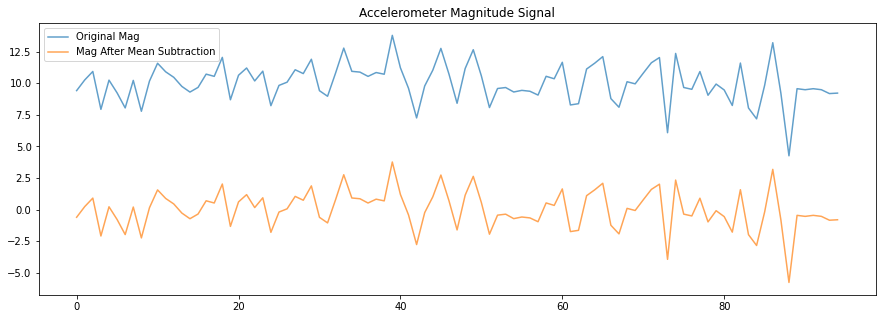

In [12]:
# Apply some basic processing. Here, we'll subtract out the mean so that the
# average of the signal is zero (this is helpful to, for example, count zero crossings)

mag_after_mean_subtraction = accel_mag - np.average(accel_mag)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_after_mean_subtraction, alpha=0.7, label="Mag After Mean Subtraction")

# set the title and show the legend
axes.set_title("Accelerometer Magnitude Signal")
axes.legend()

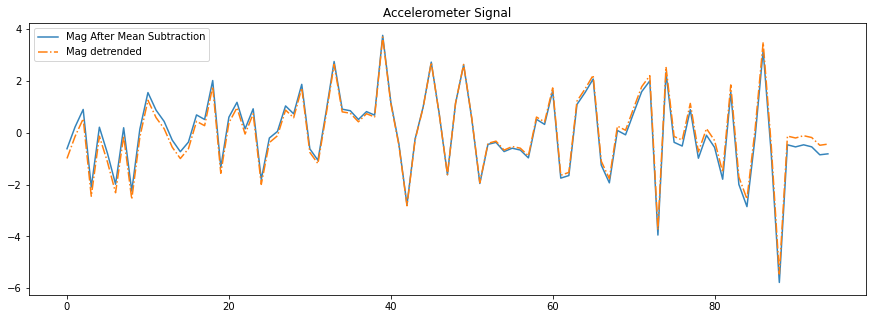

In [13]:
# We can also use scipy's built in detrend algorithm, which is the result
# of a linear least-squares fit to the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
mag_detrended = sp.signal.detrend(accel_mag) 

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_after_mean_subtraction, alpha=0.9, label="Mag After Mean Subtraction")
axes.plot(mag_detrended, alpha=1, linestyle="-.", label="Mag detrended")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()

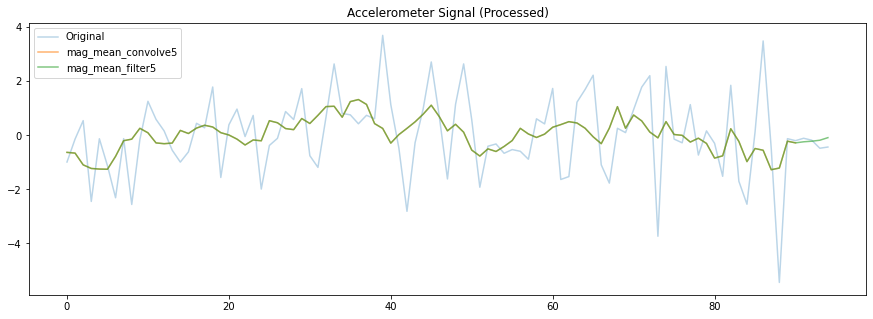

In [14]:
# Now, let's play around with various smoothing methods
# Here are different mean smoothing filters
# Note that the filter window size should really be a function of your sampling rate

def mean_filter(signal, N):
    filter_signal = np.zeros((len(signal),))
    for ctr in range(len(signal)):
         filter_signal[ctr] = np.sum(signal[ctr:(ctr+N)])
    return filter_signal/N


filter_window_size = 5

# Convolve using a mean filter
# https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
# or just use our own mean_filter code
mag_mean_convolve5 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')


mag_mean_filter5 = mean_filter(mag_detrended, filter_window_size)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_mean_convolve5, alpha=0.6, label="mag_mean_convolve5")
axes.plot(mag_mean_filter5, alpha=0.6, label="mag_mean_filter5")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Processed)")
axes.legend()

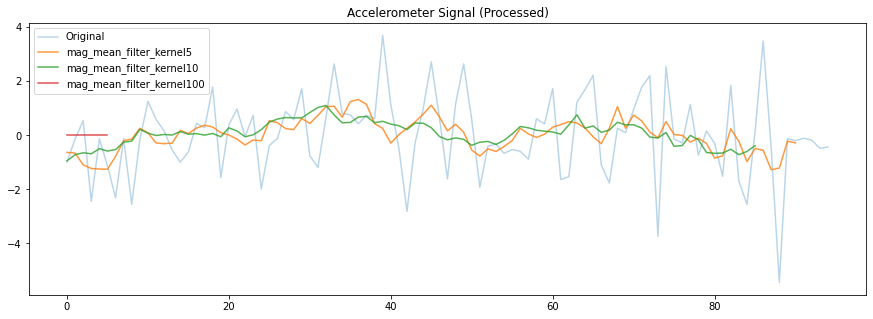

In [15]:
# Effect of various window sizes on mean filter

filter_window_size = 5

# Convolve using a mean filter
# https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
# or just use our own mean_filter code
mag_mean_filter_kernel5 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

filter_window_size = 10
mag_mean_filter_kernel10 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

filter_window_size = 100
mag_mean_filter_kernel100 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_mean_filter_kernel5, alpha=0.8, label="mag_mean_filter_kernel5")
axes.plot(mag_mean_filter_kernel10, alpha=0.8, label="mag_mean_filter_kernel10")
axes.plot(mag_mean_filter_kernel100, alpha=0.8, label="mag_mean_filter_kernel100")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Processed)")
axes.legend()

/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


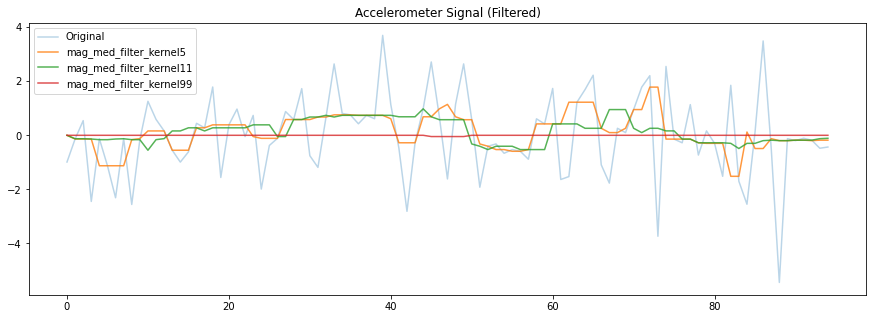

In [16]:
# median filters are easy to implement but fairly destructive
filter_window_size = 5 # should be odd
mag_med_filter_kernel5 = sp.signal.medfilt(mag_detrended, filter_window_size)

filter_window_size = 11
mag_med_filter_kernel11 = sp.signal.medfilt(mag_detrended, filter_window_size)

filter_window_size = 99
mag_med_filter_kernel99 = sp.signal.medfilt(mag_detrended, filter_window_size)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_med_filter_kernel5, alpha=0.8, label="mag_med_filter_kernel5")
axes.plot(mag_med_filter_kernel11, alpha=0.8, label="mag_med_filter_kernel11")
axes.plot(mag_med_filter_kernel99, alpha=0.8, label="mag_med_filter_kernel99")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()

In [17]:
# The Mladenov paper uses a Butterworth filter but a mean filter works well for this problem as well
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
# There are many other filters available in scipy

print("Sampling rate: {:0.2f} Hz".format(sampling_rate))
print("Maximum detectable frequency in our signal is: {:.2f} Hz (due to Nyquist theorem)".format(sampling_rate/2.0))

filter_order = 1
low_pass_cutoff_freq = 5;
nyquist_freq = 0.5 * sampling_rate
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter5 = signal.sosfilt(sos, mag_detrended)

low_pass_cutoff_freq = 3;
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter3 = signal.sosfilt(sos, mag_detrended)

low_pass_cutoff_freq = 2;
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter2 = signal.sosfilt(sos, mag_detrended)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_butter_filter5, alpha=0.8, label="mag_butter_filter5")
axes.plot(mag_butter_filter3, alpha=0.8, label="mag_butter_filter3")
axes.plot(mag_butter_filter2, alpha=0.8, label="mag_butter_filter2")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()

Sampling rate: 3.96 Hz
Maximum detectable frequency in our signal is: 1.98 Hz (due to Nyquist theorem)


ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=3.9583333333333335 -> fs/2=1.9791666666666667)

# Write your step tracker algorithm

Now, brainstorm and discuss step tracker approaches with your small group. Things to think about (and possibly try):

- What are the main characteristics of the signal that may help you detect steps? Zero crossings? Peaks?
- What sampling rate do you think is necessary to reliably detect steps? The higher the sampling rate, the 
more data to process (which will increase computational overhead, use more power, etc.). For example, if we take ~2 steps/second, how fast should we sample our accelerometer? What if we wanted to infer running as well?
    - Note: rather than changing our sampling rate at the hardware level, we could sample at a high rate and then downsample for processing
- How will you smooth your signal? Do you need/want to?
- How will you filter out noise in your signal? 
    - One way may be to filter out high-frequency components in the signal. 
    - Another way may be to only detect peaks within a certain min/max threshold. 
    - How about enforcing a minimum peak distance between two detected "walking" peaks
    - Or enforcing that all recognized steps come in a minimum set of 2 or 3
    - ... and many other ways. And you can try them rather easily in Jupyter Notebook!
    
The screenshot below shows a heuristic-based step tracking algorithm correctly identifying all steps in `arduino_accel_righthoodiepocket_3sets_15steps_delay10_9600baud_subset.csv`. Start here and then move to the more complicated cases such as `arduino_accel_leftwrist_15steps_3hops_3halfspin_3touchceiling_thenshake_nodelay_115200.csv` 

![Screenshot of accelerometer inference algorithm](https://raw.githubusercontent.com/makeabilitylab/physcomp/master/signals/assets/images/JupyterNotebook_StepTrackerVisualization_Screenshot.png)



In [ ]:
# Write your step tracking code here!

# Simulate the "real-time" system
Once you've finished with the exercise above, focus on adapting your algorithm to a "real-time" version. That is, to make this more realistic, we should really read in and buffer samples (perhaps with windows of ~1 sec long) and analyze the signal that way.

In [ ]:
print("Sampling rate: {:0.2f} Hz".format(sampling_rate))
buffer_window_size = math.floor(sampling_rate)

peak_locations = []
min_distance_between_peaks_ms = 300
min_peak_height = 10000
last_peak_timestamp = -1

for i in range(0, len(accel_mag), buffer_window_size - 1):
    
    # overlap our buffer by one sample between windows
    buffer = accel_mag[i:i+buffer_window_size]
    
    # TODO add in simple signal processing here
    # How would you detrend the signal? Perhaps an ongoing average?
    # How would you smooth the signal in an ongoing fashion?

    # Here's a simple peak detection algorithm
    for j in range(0, len(buffer) - 1):
        forward_slope = buffer[j + 1] - buffer[j]
        backward_slope = buffer[j] - buffer[j - 1]
        if forward_slope < 0 and backward_slope > 0:
            peak_index = i + j
            peak_val = buffer[j]
            #print("Found peak at index={} with val={}".format(peak_index, peak_val))
            if(peak_val >= min_peak_height):
                # print("Peak at index={} passes minimum height value ({})".format(peak_index, min_peak_height))
                time_since_last_detection_ms = accel_time[peak_index] - last_peak_timestamp
                if(last_peak_timestamp == -1 or time_since_last_detection_ms >= min_distance_between_peaks_ms):
                    last_peak_timestamp = accel_time[peak_index]
                    peak_locations.append(peak_index)
    
                
print("Found {} peaks".format(len(peak_locations)))   

# Plots the peaks
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(accel_mag, alpha=1, label="Raw mag")
axes.axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
axes.plot(peak_locations, accel_mag[peak_locations], 'y+', color="red", label="Peak Locations")


# Acknowledgments

This Notebook was designed and written by Professor Jon E. Froehlich at the University of Washington along with feedback from students. It is made available freely online as an [open educational resource](https://en.wikipedia.org/wiki/Open_educational_resources) at the teaching website: https://makeabilitylab.github.io/physcomp/. 

The [website](https://github.com/makeabilitylab/physcomp), [Notebook code](https://github.com/makeabilitylab/signals), and [Arduino code](https://github.com/makeabilitylab/arduino) are all open source using the MIT license.

Please file a GitHub Issue or Pull Request for changes/comments or email me directly.